In [1]:
import pandas as pd
from pyspark.sql.functions import col,split,concat,concat_ws,size
import re
import pyspark
import geopandas
import matplotlib.pyplot as plt

In [2]:
ds = sc.textFile("s3://mukuawsproject/devicestatus.txt")
rdd=ds.map(lambda x: (re.split('[:,|/]',x))).cache()




In [3]:
rdd=rdd.map(lambda x:(x[0],x[1],x[2],x[3],x[4],x[5],x[15],x[16]))

In [4]:
dfx = sqlContext.createDataFrame(data=rdd)


In [5]:
dfx=dfx.na.drop()

In [6]:
dfx.show(10)

+----------+---+---+---+--------------------+--------------------+-------------+--------------+
|        _1| _2| _3| _4|                  _5|                  _6|           _7|            _8|
+----------+---+---+---+--------------------+--------------------+-------------+--------------+
|2014-03-15| 10| 10| 20|       Sorrento F41L|8cc3b47e-bd01-448...|33.6894754264|-117.543308253|
|2014-03-15| 10| 10| 20|          MeeToo 1.0|ef8c7564-0a1a-465...|37.4321088904|-121.485029632|
|2014-03-15| 10| 10| 20|          MeeToo 1.0|23eba027-b95a-472...|39.4378908349|-120.938978486|
|2014-03-15| 10| 10| 20|       Sorrento F41L|707daba1-5640-4d6...|39.3635186767|-119.400334708|
|2014-03-15| 10| 10| 20|Ronin Novelty Note 1|db66fe81-aa55-43b...|33.1913581092|-116.448242643|
|2014-03-15| 10| 10| 20|       Sorrento F41L|ffa18088-69a0-433...|33.8343543748|-117.330000857|
|2014-03-15| 10| 10| 20|       Sorrento F33L|66d678e6-9c87-48d...|37.3803954321|-121.840756755|
|2014-03-15| 10| 10| 20|          MeeToo

In [7]:
dfx=dfx.select(concat('_7').alias("latitude"),concat('_8').alias("longitude"),concat_ws(':','_1','_2','_3','_4')
              .alias("date"),concat('_5').alias("model"),concat('_6').alias("deviceID"))

In [8]:
dfx.show(10)

+-------------+--------------+-------------------+--------------------+--------------------+
|     latitude|     longitude|               date|               model|            deviceID|
+-------------+--------------+-------------------+--------------------+--------------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|       Sorrento F41L|8cc3b47e-bd01-448...|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|          MeeToo 1.0|ef8c7564-0a1a-465...|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|          MeeToo 1.0|23eba027-b95a-472...|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|       Sorrento F41L|707daba1-5640-4d6...|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Ronin Novelty Note 1|db66fe81-aa55-43b...|
|33.8343543748|-117.330000857|2014-03-15:10:10:20|       Sorrento F41L|ffa18088-69a0-433...|
|37.3803954321|-121.840756755|2014-03-15:10:10:20|       Sorrento F33L|66d678e6-9c87-48d...|
|34.1841062345|  -117.9435329|2014-03-15:10:10:20|          MeeToo 4.1

In [9]:
ripdf = dfx.select('latitude','longitude','date','model','deviceID',split(dfx.model, ' ').alias('arr'))
dfx=ripdf.select('latitude','longitude','date','model','deviceID',ripdf.arr[size(ripdf.arr)-1].alias('manufacturer'))

In [10]:
dfx=dfx.filter(dfx.latitude!=0)
dfx=dfx.filter(dfx.longitude!=0)

In [11]:
dfx.show(10)

+-------------+--------------+-------------------+--------------------+--------------------+------------+
|     latitude|     longitude|               date|               model|            deviceID|manufacturer|
+-------------+--------------+-------------------+--------------------+--------------------+------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|       Sorrento F41L|8cc3b47e-bd01-448...|        F41L|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|          MeeToo 1.0|ef8c7564-0a1a-465...|         1.0|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|          MeeToo 1.0|23eba027-b95a-472...|         1.0|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|       Sorrento F41L|707daba1-5640-4d6...|        F41L|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Ronin Novelty Note 1|db66fe81-aa55-43b...|           1|
|33.8343543748|-117.330000857|2014-03-15:10:10:20|       Sorrento F41L|ffa18088-69a0-433...|        F41L|
|37.3803954321|-121.840756755|2014-03-15:10:10

In [12]:
dfx=dfx.toPandas();
dfx.to_csv('s3://mukuawsproject/devicestatus.csv',header=None)

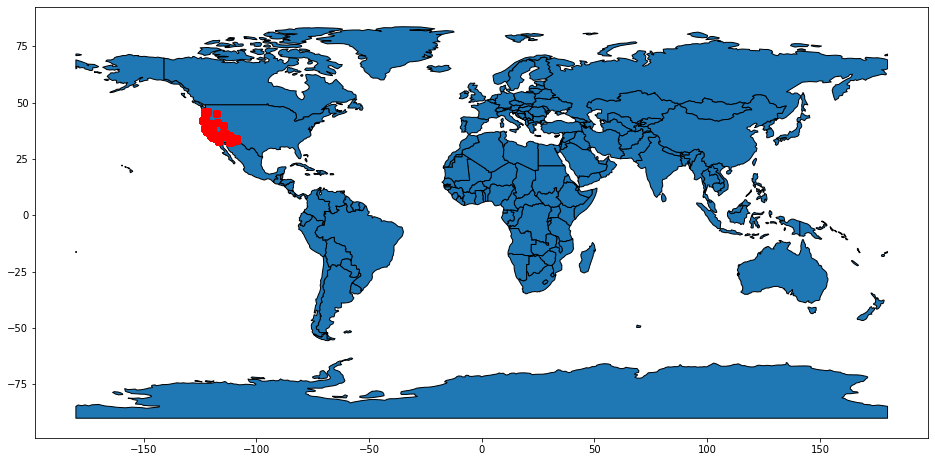

In [13]:
gdf = geopandas.GeoDataFrame(
    dfx, geometry=geopandas.points_from_xy(dfx.longitude, dfx.latitude))


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    edgecolor='black',figsize=(16,16))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='red')

plt.show()